In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import utulek

utulek.platform.import_globals(globals())
! ls {ASSETS_PATH}

/home/gilgamesh/main.syncthing/utulek/experiment/2026_01_01_whisper.ipynb.assets/
['NVIDIA GeForce GTX 1080 Ti']
podcast.1.opus	podcast.opus


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [3]:
def score_audio_segments(
    classifier,
    audio: np.ndarray,
    sr: int,
    candidate_labels: typing.List[str],
    context_len_ms: int = 16000,
    segment_overlap_ms: int = 4000,
):
    audio_padded = np.hstack(
        [audio, np.zeros((segment_overlap_ms - len(audio) % segment_overlap_ms,))]
    )
    segments = [
        audio_padded[i : i + context_len_ms * sr // 1000]
        for i in range(
            0,
            len(audio_padded) - (context_len_ms - segment_overlap_ms) * sr // 1000,
            segment_overlap_ms * sr // 1000,
        )
    ]
    scores = {i: np.zeros((len(segments),)) for i in candidate_labels}
    for i in tqdm(range(len(segments))):
        result = classifier(segments[i], candidate_labels=candidate_labels)
        for j in result:
            scores[j["label"]][i] = j["score"]

    return scores

In [4]:
def compute_p_keep_threshold(p_keep: np.ndarray):
    # We can compute threshold directly via CDF.
    p_keep_sorted = sorted(p_keep)

    # Take the lowest slope in a reasonable range.
    SLOPE_X_EPS = 0.05
    slopes = [None] * len(p_keep)
    for i in range(len(p_keep)):
        est_begin = est_end = i
        while (
            est_begin >= 0
            and p_keep_sorted[est_begin] + SLOPE_X_EPS / 2 >= p_keep_sorted[i]
        ):
            est_begin -= 1
        while (
            est_end < len(p_keep)
            and p_keep_sorted[est_end] - SLOPE_X_EPS / 2 <= p_keep_sorted[i]
        ):
            est_end += 1
        est_begin += 1
        est_end -= 1
        # Add a small EPS in case of divide by 0.
        slopes[i] = (est_end - est_begin) / (
            p_keep_sorted[est_end] - p_keep_sorted[est_begin] + 1e-9
        )

    SLOPE_IGNORE_BOUNDARY_PERCENTILE = 0.1
    threshold_i = np.argmin(
        slopes[
            int(len(slopes) * SLOPE_IGNORE_BOUNDARY_PERCENTILE) : -int(
                len(slopes) * SLOPE_IGNORE_BOUNDARY_PERCENTILE
            )
        ]
    )
    threshold = p_keep_sorted[
        int(len(slopes) * SLOPE_IGNORE_BOUNDARY_PERCENTILE) + threshold_i
    ]

    return threshold

In [5]:
def compute_cuts_keeps(
    p_keep: np.ndarray, threshold: float, context_range_segs: int = 8
):
    median_keep = (
        np.asarray(
            [
                np.percentile(
                    p_keep[max(0, i - context_range_segs) : i + context_range_segs], 25
                )
                for i in range(len(p_keep))
            ]
        )
        > threshold
    )

    cut_segs = np.hstack([-1, np.where(median_keep == 0)[0], len(median_keep)])
    keep_segs = np.hstack([-1, np.where(median_keep != 0)[0], len(median_keep)])
    keep_breaks = np.where(keep_segs + 1 != np.roll(keep_segs, -1))[0][:-1]
    cuts = keep_segs[keep_breaks] + 1, keep_segs[keep_breaks + 1]
    cut_breaks = np.where(cut_segs + 1 != np.roll(cut_segs, -1))[0][:-1]
    keeps = cut_segs[cut_breaks] + 1, cut_segs[cut_breaks + 1]
    return (cuts, keeps)

2026-01-02 17:26:55.392583: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/gilgamesh/main.syncthing/utulek/.venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
Device set to use cuda:0


  0%|          | 0/745 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Threshold: 0.4812775254249573
((array([  0, 200, 421, 686]), array([ 37, 269, 490, 745])),
 (array([ 37, 269, 490]), array([200, 421, 686])))


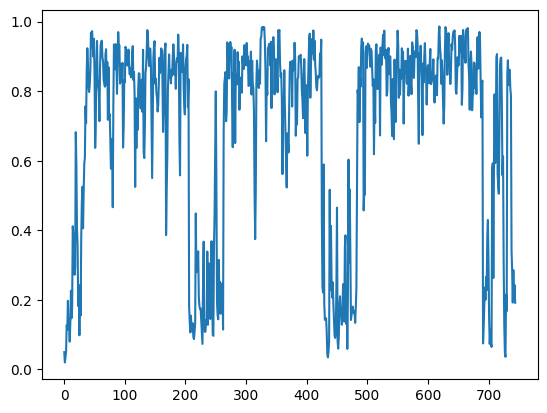

In [6]:
CANDIDATE_LABELS = ["advertisement", "podcast"]
CONTEXT_LEN_MS = 16000
SEGMENT_OVERLAP_MS = 4000
CONTEXT_RANGE_SEGS = 12

AUDIO_PATH = ASSETS_PATH + "podcast.opus"

classifier = transformers.pipeline(
    task="zero-shot-audio-classification", model="laion/clap-htsat-unfused"
)
audio, sr = librosa.load(AUDIO_PATH, sr=None)

scores = score_audio_segments(
    classifier,
    audio,
    sr,
    candidate_labels=CANDIDATE_LABELS,
    context_len_ms=CONTEXT_LEN_MS,
    segment_overlap_ms=SEGMENT_OVERLAP_MS,
)
p_keep = scores["podcast"]
threshold = compute_p_keep_threshold(p_keep)
cuts, keeps = compute_cuts_keeps(
    p_keep, threshold, context_range_segs=CONTEXT_RANGE_SEGS
)

print("Threshold:", threshold)
pp((cuts, keeps))
fig, ax = plt.subplots()
ax.plot(p_keep)
plt.show()

In [7]:
audio_cut = np.hstack(
    [
        audio[
            cuts[0][i]
            * SEGMENT_OVERLAP_MS
            * sr
            // 1000 : cuts[1][i]
            * SEGMENT_OVERLAP_MS
            * sr
            // 1000
        ]
        for i in range(len(cuts[0]))
    ]
)
audio_keep = np.hstack(
    [
        audio[
            keeps[0][i]
            * SEGMENT_OVERLAP_MS
            * sr
            // 1000 : keeps[1][i]
            * SEGMENT_OVERLAP_MS
            * sr
            // 1000
        ]
        for i in range(len(keeps[0]))
    ]
)

import soundfile as sf

sf.write(".data/podcast.cut.wav", audio_cut, sr)
sf.write(".data/podcast.keep.wav", audio_keep, sr)

Device set to use cuda:0


  0%|          | 0/792 [00:00<?, ?it/s]

Threshold: 0.55831378698349
((array([ 10, 297, 500, 768]), array([ 56, 319, 550, 792])),
 (array([  0,  56, 319, 550]), array([ 10, 297, 500, 768])))


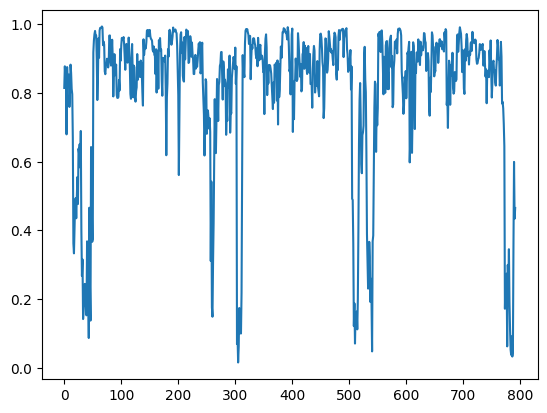

In [8]:
CANDIDATE_LABELS = ["advertisement", "podcast"]
CONTEXT_LEN_MS = 16000
SEGMENT_OVERLAP_MS = 4000
CONTEXT_RANGE_SEGS = 12

AUDIO_PATH = ASSETS_PATH + "podcast.1.opus"

classifier = transformers.pipeline(
    task="zero-shot-audio-classification", model="laion/clap-htsat-unfused"
)
audio, sr = librosa.load(AUDIO_PATH, sr=None)

scores = score_audio_segments(
    classifier,
    audio,
    sr,
    candidate_labels=CANDIDATE_LABELS,
    context_len_ms=CONTEXT_LEN_MS,
    segment_overlap_ms=SEGMENT_OVERLAP_MS,
)
p_keep = scores["podcast"]
threshold = compute_p_keep_threshold(p_keep)
cuts, keeps = compute_cuts_keeps(
    p_keep, threshold, context_range_segs=CONTEXT_RANGE_SEGS
)

print("Threshold:", threshold)
pp((cuts, keeps))
fig, ax = plt.subplots()
ax.plot(p_keep)
plt.show()

audio_cut = np.hstack(
    [
        audio[
            cuts[0][i]
            * SEGMENT_OVERLAP_MS
            * sr
            // 1000 : cuts[1][i]
            * SEGMENT_OVERLAP_MS
            * sr
            // 1000
        ]
        for i in range(len(cuts[0]))
    ]
)
audio_keep = np.hstack(
    [
        audio[
            keeps[0][i]
            * SEGMENT_OVERLAP_MS
            * sr
            // 1000 : keeps[1][i]
            * SEGMENT_OVERLAP_MS
            * sr
            // 1000
        ]
        for i in range(len(keeps[0]))
    ]
)

import soundfile as sf

sf.write(".data/podcast.1.cut.wav", audio_cut, sr)
sf.write(".data/podcast.1.keep.wav", audio_keep, sr)

In [14]:
def cut_ads(classifier, audio_path):
    CANDIDATE_LABELS = ["advertisement", "podcast"]
    CONTEXT_LEN_MS = 16000
    SEGMENT_OVERLAP_MS = 4000
    CONTEXT_RANGE_SEGS = 12

    audio, sr = librosa.load(audio_path, sr=None)

    scores = score_audio_segments(
        classifier,
        audio,
        sr,
        candidate_labels=CANDIDATE_LABELS,
        context_len_ms=CONTEXT_LEN_MS,
        segment_overlap_ms=SEGMENT_OVERLAP_MS,
    )
    p_keep = scores["podcast"]
    threshold = compute_p_keep_threshold(p_keep)
    cuts, keeps = compute_cuts_keeps(
        p_keep, threshold, context_range_segs=CONTEXT_RANGE_SEGS
    )

    audio_keep = np.hstack(
        [
            audio[
                keeps[0][i]
                * SEGMENT_OVERLAP_MS
                * sr
                // 1000 : keeps[1][i]
                * SEGMENT_OVERLAP_MS
                * sr
                // 1000
            ]
            for i in range(len(keeps[0]))
        ]
    )

    basename = os.path.basename(audio_path).rsplit(".", 1)[0]
    soundfile.write(f".data/{basename}.wav", audio_keep, sr)
    print(f"{basename}: kept {int(len(audio_keep) / len(audio) * 100)}%.")

In [15]:
classifier = transformers.pipeline(
    task="zero-shot-audio-classification", model="laion/clap-htsat-unfused"
)

for i in glob.glob("lecture/*.opus"):
    cut_ads(classifier, i)

Device set to use cuda:0


  0%|          | 0/498 [00:00<?, ?it/s]

How_The_Tech_Media_Can_Beat_The_Rot_Economy: kept 77%.


  0%|          | 0/540 [00:00<?, ?it/s]

NA-CZM_Rewind_The_Case_Against_Generative_AI__Part_1: kept 53%.


  0%|          | 0/738 [00:00<?, ?it/s]

NA-The_State_of_the_Games_Industry_with_Nathan_Grayson: kept 73%.


  0%|          | 0/702 [00:00<?, ?it/s]

The_Era_of_the_Business_Idiot,_Part_3: kept 68%.


  0%|          | 0/581 [00:00<?, ?it/s]

NA-CZM_Rewind_The_Case_Against_Generative_AI__Part_3: kept 67%.


  0%|          | 0/1465 [00:00<?, ?it/s]

Radio_Better_Offline_Paris_Martineau,_Jeff_Jarvis: kept 84%.


  0%|          | 0/1341 [00:00<?, ?it/s]

How_Sports_Gambling_Apps_Are_Rotting_Society: kept 90%.


  0%|          | 0/998 [00:00<?, ?it/s]

software-dev: kept 83%.


  0%|          | 0/140 [00:00<?, ?it/s]

Monologue_The_AI_Job_Loss_Con: kept 65%.


  0%|          | 0/177 [00:00<?, ?it/s]

Monologue_We_Need_To_Talk_About_CoreWeave: kept 76%.


  0%|          | 0/824 [00:00<?, ?it/s]

Radio_Better_Offline_Jeremy_Kaplowitz_of_the_Quorators: kept 74%.


  0%|          | 0/154 [00:00<?, ?it/s]

Monologue_Don't_Buy_A_Switch_2,_Get_A_Handheld_Gaming_PC: kept 72%.


  0%|          | 0/624 [00:00<?, ?it/s]

NA-Part_Two_NVIDIA_Isn_t_Enron_-_So_What_Is_It: kept 74%.


  0%|          | 0/571 [00:00<?, ?it/s]

SoftBank_and_OpenAI's_Dangerous_Game: kept 79%.


  0%|          | 0/623 [00:00<?, ?it/s]

OpenAI_Is_Not_A_Real_Company: kept 83%.


  0%|          | 0/140 [00:00<?, ?it/s]

NA-Monologue_The_Questions_I_m_Asking: kept 68%.


  0%|          | 0/666 [00:00<?, ?it/s]

NA-Part_Three_NVIDIA_Isn_t_Enron_-_So_What_Is_It: kept 75%.


  0%|          | 0/644 [00:00<?, ?it/s]

NA-Part_One_NVIDIA_Isn_t_Enron_-_So_What_Is_It: kept 78%.


  0%|          | 0/541 [00:00<?, ?it/s]

The_Era_of_the_Business_Idiot,_Part_1: kept 66%.


  0%|          | 0/200 [00:00<?, ?it/s]

NA-Monologue_AI_Isn_t_Getting_A_Bailout: kept 75%.


  0%|          | 0/792 [00:00<?, ?it/s]

Saving_Games_Journalism_With_Giant_Bomb: kept 81%.


  0%|          | 0/663 [00:00<?, ?it/s]

NA-The_State_of_Consumer_Tech_with_Lisa_Eadicicco: kept 83%.


  0%|          | 0/180 [00:00<?, ?it/s]

Monologue_The_Super_Bowl_Showed_That_Generative_AI_Is_Washed: kept 76%.


  0%|          | 0/167 [00:00<?, ?it/s]

Monologue_OpenAI_Is_Getting_Desperate: kept 67%.


  0%|          | 0/202 [00:00<?, ?it/s]

Monologue_OpenAI_Vs_Microsoft: kept 73%.


  0%|          | 0/779 [00:00<?, ?it/s]

The_Slop_Society: kept 71%.


  0%|          | 0/436 [00:00<?, ?it/s]

Microsoft_Cuts_The_Power_To_AI: kept 73%.


  0%|          | 0/132 [00:00<?, ?it/s]

Monologue_How_Does_This_End: kept 74%.


  0%|          | 0/1358 [00:00<?, ?it/s]

Radio_Better_Offline_Cherlynn_Low,_Alex_Cranz_Victoria_Song: kept 91%.


  0%|          | 0/805 [00:00<?, ?it/s]

The_Better_Offline_Mailbag: kept 69%.


  0%|          | 0/613 [00:00<?, ?it/s]

NA-CZM_Rewind_The_Case_Against_Generative_AI__Part_2: kept 69%.


  0%|          | 0/1056 [00:00<?, ?it/s]

Radio_Better_Offline_Andy_Richter: kept 89%.


  0%|          | 0/205 [00:00<?, ?it/s]

Monologue_What_Bursts_A_Bubble: kept 80%.


  0%|          | 0/1166 [00:00<?, ?it/s]

How_Growth_Is_Killing_Video_Games: kept 85%.


  0%|          | 0/621 [00:00<?, ?it/s]

The_Era_of_the_Business_Idiot,_Part_2: kept 72%.


  0%|          | 0/240 [00:00<?, ?it/s]

Monologue_High_Noon_for_CoreWeave_AI: kept 82%.


  0%|          | 0/609 [00:00<?, ?it/s]

What_The_Hell_Is_DeepSeek: kept 70%.


  0%|          | 0/585 [00:00<?, ?it/s]

What_We're_Fighting_For: kept 84%.


  0%|          | 0/1420 [00:00<?, ?it/s]

Radio_Better_Offline_Pablo_Torre_and_David_Roth: kept 86%.


  0%|          | 0/198 [00:00<?, ?it/s]

Monologue_OpenAI_Was_Never_A_Non-Profit: kept 79%.


  0%|          | 0/745 [00:00<?, ?it/s]

NA-Is_Valve_Taking_On_Microsoft_with_Steve_Burke: kept 67%.


  0%|          | 0/730 [00:00<?, ?it/s]

Generative_AI_Is_Not_A_Real_Industry: kept 83%.
